# Question 2: Implementing Backpropagation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import UClasses
import copy

# Preliminaries

## Dataset

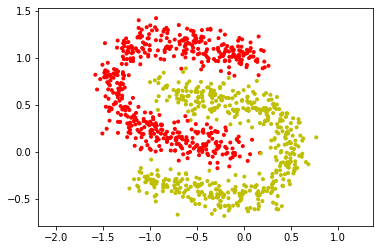

In [2]:
ds = UClasses(n=1000)
ds.plot()

## `Operation` class: Activation/Loss functions

In [3]:
class Operation(object):
    '''
     Operation class
     
     This is the abstract base class that other operations should be based on.
    '''
    def __init__(self):
        raise NotImplementedError

    def __call__(self, x):
        raise NotImplementedError

    def derivative(self):
        raise NotImplementedError

### Activation functions

In [4]:
class Identity(Operation):
    '''
     act = Identity()
     
     Creates an Operation object that represents the identity mapping.
     
     Usage:
      act = Identity()
      act(np.array([[1.2, 5.]]))
     produces the numpy array
      [[1.2, 5.]]
    '''
    def __init__(self):
        return
        
    def __call__(self, z):
        '''
         y = act(z)
         
         Evaluates the identity function, element-by-element, on z.
         
         Input:
          z  is a numpy array
         Output:
          y  is a numpy array the same size as z
        '''
        #===== YOUR CODE HERE =====
        self.dims = z.shape
        return z
    
    def derivative(self, s=None):
        '''
         act.derivative(s=None)
         
         Computes the derivative of the identity mapping
         element-by-element.
         Note that the __call__ function must be called before this
         function can be called.
         
         Input:
           s       array the same size as z, which multiplies the
                   derivative
           
         Output:
           dactdz  array the same size as z when __call__ was called,
                   and is s times the derivative
           
         Usage:
           dactdz = act.derivative()
           dactdz = act.derivative(s)
        '''
        #===== YOUR CODE HERE =====
        return np.ones(self.dims)  # replace this line
        
class Logistic(Operation):
    '''
     act = Logistic()
     
     Creates an Operation object that represents the logistic
     function.
     
     Usage:
      act = Logistic()
      act(np.array([0., 0.5]))
     produces the numpy array
      [0.5 , 0.62245933]
    '''
    def __init__(self):
        return
        
    def __call__(self, z):
        '''
         y = act(z)
         
         Evaluates the logistic function, element-by-element, on z.
         
         Input:
          z  is a numpy array
         Output:
          y  is a numpy array the same size as z
        '''
        # Save the output value to use in the derivative
        self._out = 1/(1+np.exp(-z))
        return self._out
    
    def derivative(self, s=None):
        '''
         act.derivative(s=None)
         
         Computes the derivative of the logistic function
         element-by-element.
         Note that the __call__ function must be called before this
         function can be called.
         
         Input:
           s       array the same size as z, which multiplies the
                   derivative
           
         Output:
           dactdz  array the same size as z when __call__ was called,
                   and is s times the derivative

         Usage:
           dactdz = act.derivative()
           dactdz = act.derivative(s)
        '''
        #===== YOUR CODE HERE =====
        derivative = self._out * (1 - self._out)  # \sigma(z)(1-sigma(z))
        return derivative * s if s else derivative

### Loss functions

In [5]:
class MSE(Operation):
    '''
     E = MSE()
     
     Creates an object that implements the mean squared error loss.
     
     Usage:
      E = MSE()
      loss = E(y, t)
      
     Example:
      y = np.array([[0.5, 0.1],[-0.4, 0.9], [-0.1, 0.4]])
      t = np.array([[0.6, 0.1],[-0.4, 0.7], [-0.1, 0.6]])
      loss = E(y, t)
     produces the value
      0.015  since it equals
      (0.1^2 + 0.2^2 + 0.2^2)/2 / 3
    '''
    def __init__(self):
        self.dE = []
    
    def __call__(self, y, t):
        '''
         E.__call__(y, t)  or   E(y, t)
         
         Computes the mean (average) squared error between the outputs
         y and the targets t.
         
         Inputs:
           y  array with one sample per row
           t  array the same size as y
           
         Output:
           loss  MSE loss (scalar)
        '''
        # MSE formula
        self.n_samples = np.shape(t)[0]
        E = np.sum((y-t)**2)/2./self.n_samples
        self.dE = (y-t) / self.n_samples
        return E

    def derivative(self):
        '''
         E.derivative()
         
         Computes and the derivative of the MSE with respect to y.
         Note that the __call__ function must be called before this
         function can be called.
         
         Output:
           dEdy  array the same size as y when __call__ was called
        '''
        # Compute the gradient of MSE w.r.t. output
        return self.dE

        
class CrossEntropy(Operation):
    '''
     E = CrossEntropy()
     
     Creates an object that implements the average cross-entropy loss.
     
     Usage:
      E = CrossEntropy()
      loss = E(y, t)
    '''
    def __init__(self):
        return
    
    def __call__(self, y, t):
        '''
         E.__call__(y, t)  or   E(y, t)
         
         Computes the average cross-entropy between the outputs
         y and the targets t.
         
         Inputs:
           y  array with one sample per row
           t  array the same size as y
           
         Output:
           loss  average CE loss (scalar)
        '''
        # Check that inputs are in the expected ranges
        assert ((y < 1.) & (y > 0.)).all(), y
        assert ((t <= 1.) & (t >= 0.)).all(), t
        
        # Save values needed to compute derivatives
        self._y, self._t = y, t
        
        # Compute cross entropy
        E = - np.sum(t*np.log(y) + (1-t)*np.log(1-y))
        return E / y.shape[0]  # average across batch

    def derivative(self):
        '''
         E.derivative()
         
         Computes and the derivative of cross-entropy with respect to y.
         Note that the __call__ function must be called before this
         function can be called.
         
         Output:
           dEdy  array the same size as y when __call__ was called
        '''
        #===== YOUR CODE HERE =====
        dE_sum = -self._t/self._y + (1-self._t)/(1-self._y)  # gradient for sum
        return dE_sum / self._y.shape[0]  # gradient for average loss


## `Layer` Classes

In [6]:
class Layer(object):
    def __init__(self):
        return

    def __call__(self, x):
        raise NotImplementedError


class Population(Layer):
    '''
     lyr = Population(nodes, act=Identity())

     Creates a Population layer object.

     Inputs:
       nodes  the number of nodes in the population
       act    activation function (Operation object)
       
     Usage:
       lyr = Population(3, act=Logistic())
       h = lyr(z)
       print(lyr())   # prints current value of lyr.h
    '''

    def __init__(self, nodes, act=Identity()):
        self.nodes = nodes
        self.z = None
        self.h = None
        self.act = act
        self.params = []

    def __call__(self, x=None):
        if x is not None:
            self.z = x
            self.h = self.act(x)
        return self.h


class Connection(Layer):
    '''
     lyr = Connection(from_nodes=1, to_nodes=1)

     Creates a layer of all-to-all connections.

     Inputs:
       from_nodes  number of nodes in source layer
       to_nodes    number of nodes in receiving layer

     Usage:
       lyr = Connection(from_nodes=3, to_nodes=5)
       z = lyr(h)
       lyr.W    # matrix of connection weights
       lyr.b    # vector of biases
    '''

    def __init__(self, from_nodes=1, to_nodes=1):
        super().__init__()

        self.W = np.random.randn(from_nodes, to_nodes) / np.sqrt(from_nodes)
        self.b = np.zeros(to_nodes)
        self.params = [self.W, self.b]

    def __call__(self, x=None):
        if x is None:
            print('Should not call Connection without arguments.')
            return
        P = len(x)
        if P>1:
            return x@self.W + np.outer(np.ones(P), self.b)
        else:
            return x@self.W + self.b


class DenseLayer(Layer):
    '''
     lyr = DenseLayer(from_nodes=1, to_nodes=1, act=Logistic())

     Creates a DenseLayer object, composed of 2 layer objects:
       L1  a Connection layer of connection weights, and
       L2  a Population layer, consisting of nodes that receives current
           from the Connection layer, and apply the activation function

     Inputs:
       from_nodes  how many nodes are in the layer below
       to_nodes    how many nodes are in the new Population layer
       act         activation function (Operation object)
       
     Usage:
       lyr = DenseLayer(from_nodes=3, to_nodes=5)
       h2 = lyr(h1)
       lyr.L1.W        # connection weights
       lyr.L2()        # activities of layer
       lyr.L2.act      # activation function of layer
    '''

    def __init__(self, from_nodes=1, to_nodes=1, act=Logistic()):
        self.L1 = Connection(from_nodes=from_nodes, to_nodes=to_nodes)
        self.L2 = Population(from_nodes, act=act)

    def __call__(self, x=None):
        if x is None:
            return self.L2.h
        else:
            # Calculate and return the operation of the two layers, L1 and L2
            return self.L2(self.L1(x))

# `Network` Class (*action required*)

In [7]:
class Network(object):
    '''
     net = Network()

     Creates a Network object.
     
     Usage:
       net = Network()
       net.add_layer(L)
       ... (add more layers)
       y = net(x)
       net.lyr[1]    # reference to Layer object
    '''

    def __init__(self):
        self.lyr = []
        self.loss = None

    def add_layer(self, L):
        '''
         net.add_layer(L)
         
         Adds the layer object L to the network.
         
         Note: It is up to the user to make sure the Layer object
               fits with adjacent layers.
        '''
        self.lyr.append(L)

    def __call__(self, x):
        '''
         y = net(x)
         
         
         Input:
           x  batch of inputs, one input per row
           
         Output:
           y  corresponding outputs, one per row
        '''
        for l in self.lyr:
            x = l(x)
        return x

    def learn(self, ds, lrate=1., epochs=10):
        '''
         net.Learn(ds, lrate=1., epochs=10)

         Runs backprop on the network, training on the data from
         the Dataset object ds.
         
         Inputs:
           ds       a Dataset object
           lrate    learning rate
           epochs   number of epochs to run
        '''
        #========== Question 2, part (b) ==========
        # TODO: Complete the code below.
        # You will have to edit all these lines.
        #=== MIGHT I INTEREST YOU IN ADDING SOME CODE HERE? ===
        
        loss_history = []  # for plotting
        x, t = ds.inputs(), ds.targets()
        for epoch in range(epochs):
            cost = self.loss(self(x), t)  # forward pass
            self.backprop(t, lrate=lrate)  # backward pass
                
            if epoch%100==0:
                loss_history.append(cost)
                print(f'{epoch}: cost = {cost}')
        return np.array(loss_history)  # don't touch this line
            


    def backprop(self, t, lrate=1.):
        '''
         net.backprop(t, lrate=1.)
         
         Using the error between the state of the output layer and
         the connection weights and biases.
         
         NOTE: This method assumes that the network is in the
         
         Inputs:
           t      batch of targets, one per row
           lrate  learning rate
        '''
        #========== Question 2, part (a) ==========
        # TODO: Complete the code below.
        # You will have to alter all the lines.
        
        # Set up top gradient
        dEdh = self.loss.derivative()
        # Work our way down through the layers
        for i in range(len(self.lyr)-1, 0, -1):
            # References to the layer below, and layer above
            pre = self.lyr[i-1]   # layer below, (i-1)
            post = self.lyr[i]    # layer above, (i)
            # Note that:
            #   post.L1.W contains the connection weights
            #   post.L1.b contains the biases
            #   post.L2.z contains the input currents
            #   post.L2.h contains the upper layer's activities
            # Compute dEdz from dEdh
            dEdz = dEdh * post.L2.act.derivative()
            # Parameter gradients
            h = pre.h if isinstance(pre, Population) else pre.L2.h
            dEdW = h.T @ dEdz  # shape == post.L1.W.shape
            dEdb = dEdz.sum(axis=0)  # shape == post.L1.b.shape
            # Project gradient through connection, to layer below
            dEdh = dEdz @ post.L1.W.T  # shape == pre.h.shape
            # Update weight parameters
            post.L1.W -= lrate * dEdW
            post.L1.b -= lrate * dEdb

# Your code should work below

In [8]:
net = Network()

# Create layers
input_layer = Population(2)
h1 = DenseLayer(from_nodes=2, to_nodes=30, act=Logistic())
h2 = DenseLayer(from_nodes=30, to_nodes=10, act=Logistic())
output_layer = DenseLayer(from_nodes=10, to_nodes=2, act=Logistic())

# Add layers to the network, from bottom to top
net.add_layer(input_layer)
net.add_layer(h1)
net.add_layer(h2)
net.add_layer(output_layer)

# Choose a loss function
net.loss = CrossEntropy()

0: cost = 1.5652268249097356
100: cost = 0.8352599749560391
200: cost = 0.8279335569606824
300: cost = 0.8234084305965079
400: cost = 0.8176361063758208
500: cost = 0.8110494624274674
600: cost = 0.8006635451506932
700: cost = 0.7695409735341312
800: cost = 0.6837062226089253
900: cost = 0.5798409540587678
1000: cost = 0.29451621485943286
1100: cost = 0.1702939721093587
1200: cost = 0.12235035618977079
1300: cost = 2.342715495127134
1400: cost = 0.10472009477508677
1500: cost = 0.09864507787568025
1600: cost = 0.09471206060602762
1700: cost = 0.09183312403786145
1800: cost = 0.08954661597816513
1900: cost = 0.08759285590094575
2000: cost = 0.08582012851186224
2100: cost = 0.08413931001164764
2200: cost = 0.082498113770728
2300: cost = 0.08086650744086787
2400: cost = 0.07922851918847655
2500: cost = 0.07757712438477933
2600: cost = 0.07591029597566376
2700: cost = 0.07422759931275118
2800: cost = 0.07252746198218121
2900: cost = 0.07080536261524557
3000: cost = 0.06905296121613169
3100

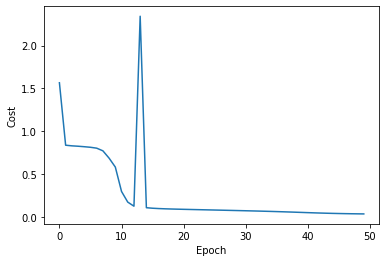

In [9]:
# Train the network
loss_history = net.learn(ds, epochs=5000);

# Plot the progress of the cost
plt.plot(loss_history);
plt.xlabel('Epoch')
plt.ylabel('Cost');

In [10]:
# Sanity check, to see if output match targets
y = net(ds.inputs())
print(f'Outputs:\n{y[:5,:]}')
print(f'Targets:\n{ds.targets()[:5,:]}')

Outputs:
[[9.98484966e-01 1.57179678e-03]
 [2.03485730e-03 9.97913255e-01]
 [9.99990579e-01 9.53006716e-06]
 [9.99509193e-01 4.86801306e-04]
 [4.18953693e-05 9.99959049e-01]]
Targets:
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


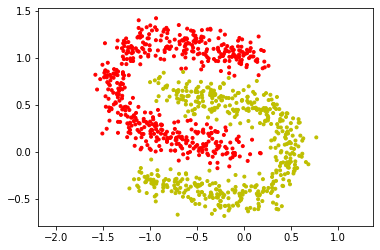

In [11]:
# Cluster plot to make us feel accomplished!
ds.plot(labels=y)

# Evaluate your model (*action required*)

In [12]:
def accuracy(y, t):
    '''
     ac = accuracy(y, t)
     
     Calculates the fraction of correctly classified samples.
     A sample is classified correctly if the largest element
     in y corresponds to where the 1 is in the target.
     
     Inputs:
       y  a batch of outputs, with one sample per row
       t  the corresponding batch of targets
       
     Output:
       ac the fraction of correct classifications (0<=ac<=1)
    '''
    return (y.argmax(-1) == t.argmax(-1)).mean()


In [13]:
ac = accuracy(net(ds.inputs()), ds.targets())
print(f'Model training accuracy = {ac*100}%')

Model training accuracy = 99.5%
